# Approximating a Reflection Map

In this tutorial we show how to painlessly train a neural ODE for approximating the **reflection map** 

$$
    y = -x
$$

This tutorial also serves as a warning on limitations of *vanilla* ODE models which should always be considered when designing your task-specific architecture.\
In fact, vanilla Neural ODEs cannot approximate (in 1D) functions which requires the flows to cross, e.g. the reflection map $y=-x$ as they would break the uniqueness of solutions (and thus the determinism). As we show later, one way to overcome this issue is to employ **data-controlled** models.

In [27]:
from torchdyn.core import NeuralODE
from torchdyn.nn import DataControl, DepthCat, Augmenter
from torchdyn.utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
# quick run for automated notebook validation
dry_run = False

**Data**

The dataset contains pairs of `(-1, 1)` and `(1, -1)`

In [29]:
import torch
import torch.utils.data as data

n_points = 100
X = torch.linspace(-1,1, n_points).reshape(-1,1)
y = -X

device = "cpu" # feel free to run on GPU  
X_train, y_train = torch.Tensor(X).to(device), torch.Tensor(y).to(device)

bs = len(X)
train = data.TensorDataset(X_train, y_train)
trainloader = data.DataLoader(train, batch_size=bs, shuffle=False)

**Learner**

In [30]:
import torch.nn as nn
import pytorch_lightning as pl


class Learner(pl.LightningModule):
    def __init__(self, t_span, model:nn.Module, settings:dict={}):
        super().__init__()
        self.model, self.t_span = model, t_span
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch      
        t_eval, yhat = self.model(x, self.t_span)
        yhat = yhat[-1] # select last point of solution trajectory
        loss = nn.MSELoss()(yhat, y)
        return {'loss': loss}  
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01)

    def train_dataloader(self):
        return trainloader

## Uncontrolled Neural ODE models

We first consider the following neural ODE variants: `depth-invariant` and `depth-variant` ("cat"). As we expect, these models will **NOT** be able to approximate the reflection map.

In [31]:
# vanilla depth-invariant
func = nn.Sequential(
        nn.Linear(1, 64),
        nn.Tanh(),
        nn.Linear(64,1)
        ).to(device)


# vanilla depth-variant
func_dv = nn.Sequential(DepthCat(1),
        nn.Linear(2, 64),
        nn.Tanh(),
        nn.Linear(64,1)
        ).to(device)

funcs = [func, func_dv]

t_span = torch.linspace(0,1,100)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
/home/michael/.cache/pypoetry/virtualenvs/torchdyn-voYSR01p-py3.8/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  warnings.warn(*args, **kwargs)

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 193   
------------------------------------
193       Trainable params
0         Non-trainable params
193       Total params
0.001     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/home/michael/.cache/pypoetry/virtualenvs/torchdyn-voYSR01p-py3.8/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
/home/michael/.cache/pypoetry/virtualenvs/torchdyn-voYSR01p-py3.8/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  warnings.warn(*args, **kwargs)

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 257   
------------------------------------
257       Trainable params
0         Non-trainable params
257       Total params
0.001     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/home/michael/.cache/pypoetry/virtualenvs/torchdyn-voYSR01p-py3.8/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

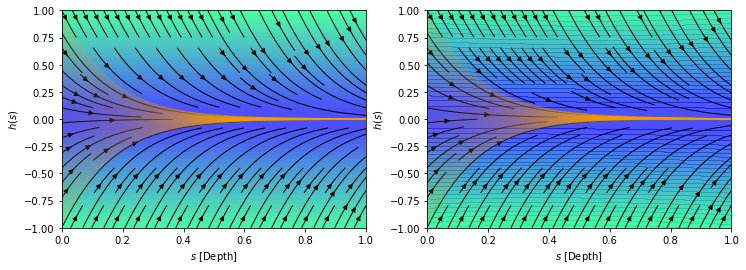

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plot_settings = {'n_grid':30, 'x_span':[-1,1], 'device':device}

for i, f in enumerate(funcs):
    # define the model
    model = NeuralODE(f, solver='dopri5', sensitivity='interpolated_adjoint', atol=1e-3, rtol=1e-3).to(device)
    # train the neural ODE
    learn = Learner(t_span, model)
    if dry_run: trainer = pl.Trainer(max_epochs=1) 
    else: trainer = pl.Trainer(max_epochs=200)
    trainer.fit(learn)
    
    # plot the learned flows
    plt.subplot(1,2,1+i)
    _, traj = model.cpu().trajectory(X_train.cpu(), t_span)
    plot_traj_vf_1D(model, t_span, traj.detach(), n_grid=30, x_span=[-1,1], device=device);

## Controlled Neural ODE models

Following the work in [Massaroli S., Poli M., et al., 2020](https://arxiv.org/abs/2002.08071), we can easily approximate the reflection map leveraging **data-controlled Neural ODEs**. Data-control allows the Neural ODE to learn a family of vector fields instead of a single one, via conditioning the vector field `f` with the initial condition `x`.

In [33]:
# define the data-controlled model
f = nn.Sequential(DataControl(),
                  nn.Linear(2, 64),
                  nn.Tanh(),
                  nn.Linear(64,1)
).to(device)

model = NeuralODE(f, solver='dopri5').to(device)

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


In [34]:
# train the neural ODE
learn = Learner(t_span, model)
if dry_run: trainer = pl.Trainer(max_epochs=1) 
else: trainer = pl.Trainer(max_epochs=200)
trainer.fit(learn)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
/home/michael/.cache/pypoetry/virtualenvs/torchdyn-voYSR01p-py3.8/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  warnings.warn(*args, **kwargs)

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 257   
------------------------------------
257       Trainable params
0         Non-trainable params
257       Total params
0.001     Total estimated model params size (MB)
/home/michael/.cache/pypoetry/virtualenvs/torchdyn-voYSR01p-py3.8/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLo

Training: 0it [00:00, ?it/s]

**Plots**

In [35]:
# evaluate the trajectories of each data point
t_span = torch.linspace(0,1,100)
_, traj = model.trajectory(X_train, t_span)
traj = traj.cpu().detach()

Text(0.5, 1.0, 'Depth-Trajectories of Controlled Neural ODEs')

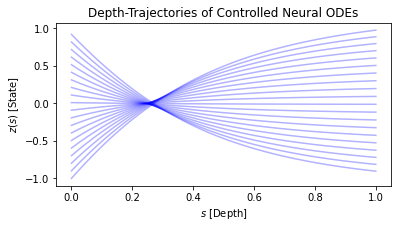

In [36]:
# plot the depth evolution of the data
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(111)
ax.plot(t_span, traj[:,::5,0], color='blue', alpha=.3);
ax.set_xlabel(r"$s$ [Depth]")
ax.set_ylabel(r"$z(s)$ [State]")
ax.set_title(r"Depth-Trajectories of Controlled Neural ODEs")

<ipython-input-37-64404c571f26>:6: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  fig = plt.figure(figsize=(6,6)) ; ax =Axes3D(fig)


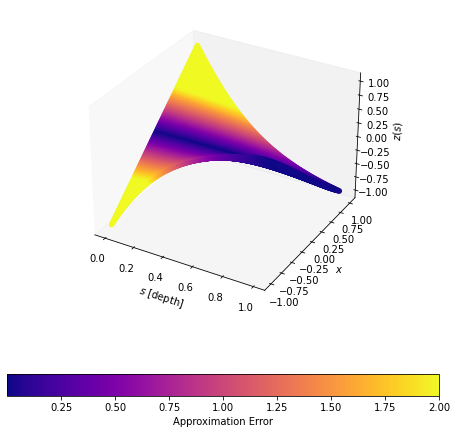

In [37]:
# plot the evolution of the data in the s-x-h space
from mpl_toolkits.mplot3d import Axes3D

n_grid=30
x_span=[-1,1]
fig = plt.figure(figsize=(6,6)) ; ax =Axes3D(fig)
ss = torch.linspace(t_span[0], t_span[-1], n_grid)
xx = torch.linspace(x_span[0], x_span[-1], n_grid)
S, X = torch.meshgrid(ss,xx) ; 
u_traj = traj[0,:,0].repeat(traj.shape[1],1)
e = torch.abs(y.T - traj[:,:,0])
color = plt.cm.plasma(e.numpy())
for i in range(traj.shape[1]):
    tr = ax.scatter(t_span, u_traj[:,i], traj[:,i,0],
                c=color[:,i],alpha=1, cmap=color[:,i], zdir='z')
norm = mpl.colors.Normalize(e.min(),e.max())
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='plasma'),
     label='Approximation Error', orientation='horizontal')
ax.set_xlabel(r"$s$ [depth]"); ax.set_ylabel(r"$x$"); ax.set_zlabel(r"$z(s)$") ; 
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)